In [1]:
%pip install pandas 
%pip install python-dotenv
%pip install -U scikit-learn
%pip install sun_position_calculator
%pip install requests
%pip install docxtpl
%pip install matplotlib
%pip install tabulate
%pip install pyxirr
%pip install openpyxl
%pip install folium
%pip install html2image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#local models
from typing import Dict
from models.econometrics import Cost, Currency
from models.components import Component
from models.econometrics import Cost
from models.geometry import Orientation

#init project
from models.components import Tech
from models.consumption import Energetic
from models.inventory import Building, Project
import pandas as pd

In [3]:
#local env variables
from dotenv import dotenv_values
config = dotenv_values(".env.local")

# Building references

## Address and general info🌎

## Energy Consumptions🔌

In [4]:
#cspell:disable


project:Project = Project(
    title='Sistema PV MHNV OnGrid-Mixto',
    building = Building(
        geolocation=(-33.047016, -71.621509),
        name='Edificio Carlos Porter MHNV',
        address='Calle Condell 1546',
        city='Valparaíso'),
    technology= [Tech.PHOTOVOLTAIC],
    consumption= {
        'description':'main',
        'energetic':Energetic.ELI,
        'cost_increment':8/100,
        'consumption':[
            (1051,"01-02-2023",97361),
            (1123,"02-03-2023",104031),
            (1157,"03-04-2023",107181),
            (1220,"04-05-2023",137911),
            (1299,"01-06-2023",146841),
            (1549,"04-07-2023",175101),
            (1353,"02-08-2023",152946),
            (1420,"01-09-2023",160519),
            (1283,"03-10-2023",145033),
            (1275,"03-11-2023",144128),
            (1346,"03-12-2023",152155),
            (1438,"03-01-2024",162554),

            ],
        }
    )

getting weather data...
api request URL https://power.larc.nasa.gov/api/temporal/hourly/point?Time=LST&parameters=T2M,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_SRF_ALB,SZA,WS10M&community=RE&latitude=-33.047016&longitude=-71.621509&start=20230101&end=20231231&format=JSON
getting currencies data...
set $1 Pesos chileno.. on USD$0.00 
set $1 UF............. on USD$39.32 
set $1 UTM............ on USD$68.96 
set $1 Euro........... on USD$1.05 
set $1 Pound.......... on USD$1.28 
set $1 Real........... on USD$0.17 
adding consumptions data...


# Integration 

## Machine Components 🎡

In [5]:
#cspell: disable
#repository of reusable components
from libs.repository import repoEquipment,panelRepo
from models.components import Specs
#clean previous load
project.components = {}

from IPython.display import clear_output

from models.energy_storage import Battery
from models.photovoltaic import PvInput
clear_output(wait=True)

# assembly projects components
project.add_generator(
    panelRepo['CS 655W'],# equipment
    PvInput(
        description='FV 655W MOD 01',
        quantity=9,
        orientation=Orientation(35,28),
        ),
    PvInput(
        description='FV 655W MOD 02',
        quantity=11,
        orientation=Orientation(20,28),
        ),
    PvInput(
        description='FV 655W MOD 03',
        quantity=4,
        orientation=Orientation(10,28),
    )
    
)

#nominal power
pj_power = project.nominal_power

# Energy process
project.add_component(
    'Instalación',
    repoEquipment['Inverter']['DY 12kW H'],# ./../libs/repository.py
    repoEquipment['Medidor']['FR 3F'],# lectura
    Component(
    description='eléctrica interior',
    specification=Specs(
        category='Obra',
        brand='conexionado',
        model='interiores'
        ),
    cost_per_unit=Cost(225_000,currency=Currency.CLP),
    quantity=int(project.nominal_power[0])
    ),
Component(
    description='est. de montaje',
    specification=Specs(
        category='Montaje',
        montaje='coplanar',
        ),
    cost_per_unit=Cost(45_000,Currency.CLP),
    quantity=project.n_generator
    ),
)

# BESS & Storage
has_storage:bool = True

if has_storage:
    project.add_component(
        'Almacenamiento',
        repoEquipment['Regulator']['VT 45A'],
        repoEquipment['Monitor']['VC 700'],#
        Battery(
            description='Baterías',
            specifications=Specs(
                category='Storage',
                brand='MaxPower',
                model='MP GEL12-250',
                ref_url='https://www.tiendatecnored.cl/bateria-gel-ciclo-profundo-12v-250ah.html',
                specs_url='https://www.tiendatecnored.cl/media/wysiwyg/ficha-tecnica/4703148.pdf',
                clase='Ciclo Profundo',
                tipo='GEL'
                ),
            cost_per_unit=Cost(305_990,Currency.CLP),
            volt=12,
            charge=250,
            demand=project.building.consumption_forecast(['main'])['energy'].to_list(),
            hours_autonomy=4,
            use_regime='8/5',
        ),
    )

# obras y accesorios
project.add_component(
    'Obras',
    # Component(
    #     description='Instalación eléctrica',
    #     specification=Specs(
    #         category='Obra',
    #         brand='horas instaladores',
    #         model='/HP.'
    #         ),
    #     cost_per_unit=Cost(1,currency=Currency.UF),
    #     quantity=project.n_generator*5,
    #     ),
    Component(
        description='Faenas',
        specification=Specs(
            category='Obra',
            brand='equipamiento',
            model='provisorio'),
        cost_per_unit=Cost(18_750,Currency.CLP),
        quantity=project.n_generator
        ),
    Component(
        description='Capacitación',
        specification=Specs(
            category='Obra',
            brand='Uso y',
            model='mantenimiento',
            taller='2 Hrs',
            manual='3 u. impreso',
            ),
        cost_per_unit=Cost(250_000,Currency.CLP),
        ),
    Component(
        description='Letrero',
        specification=Specs(
            category='Obra',
            brand='pliego',
            model='estructura',
            specs_url='#pliegos-técnicos',
            dim='3.6m x 1.5m',
            ),
        cost_per_unit=Cost(450_000,Currency.CLP),
        )
)

inside cost pv :  208547.06 Currency.CLP
inside cost pv :  208547.06 Currency.CLP
inside cost pv :  208547.06 Currency.CLP


In [6]:
#calculate bucket overloads
project.bucket.set_overloads(gastos_gral=15,utilidad=10)


# Write Document 📒


In [7]:
import os
PATH = 'build/'+f'r_{project.building.city.lower()[:3]}_{project.building.name}/'

if not os.path.exists(PATH):
    #create
    os.makedirs(PATH)

### Saving results on EXCEL ❎

In [8]:
from models.plotter import to_table
to_table(project,PATH)

### Generate Context->Doc📄✍️

In [9]:
from docxtpl import DocxTemplate # type: ignore
#init doc
#assembly proxy object 
memory_report = DocxTemplate("templates/memory_template.docx")
bidding_report = DocxTemplate("templates/bidding_template.docx")

## Write params and tables

In [10]:
#loading context
#cspell: disable
memory_report.render(project.context(template=memory_report))
bidding_report.render(project.context(template=bidding_report))


## Insert Plots 📊

c:\Users\crcam\Dev\pv-report-modeler\models\plotter.py:146: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot = module.fillna(0).pivot_table(
c:\Users\crcam\Dev\pv-report-modeler\models\plotter.py:146: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot = module.fillna(0).pivot_table(
c:\Users\crcam\Dev\pv-report-modeler\models\plotter.py:146: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `p

plot_done


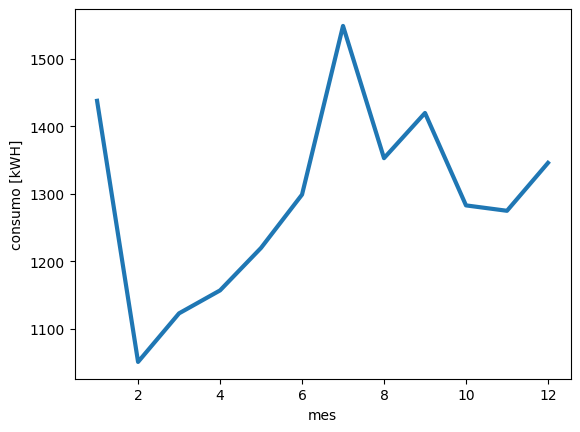

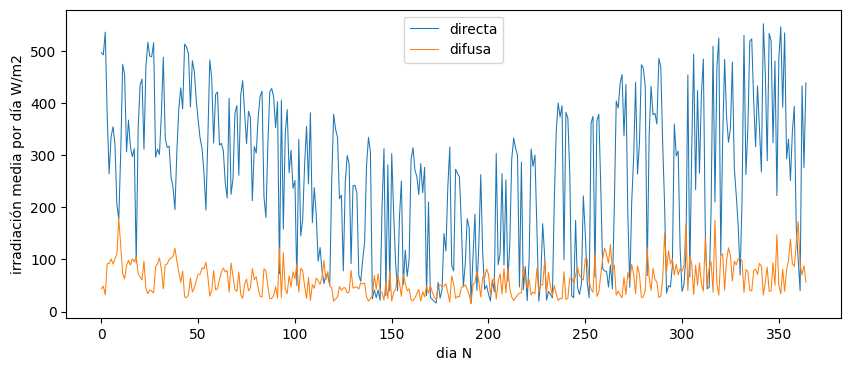

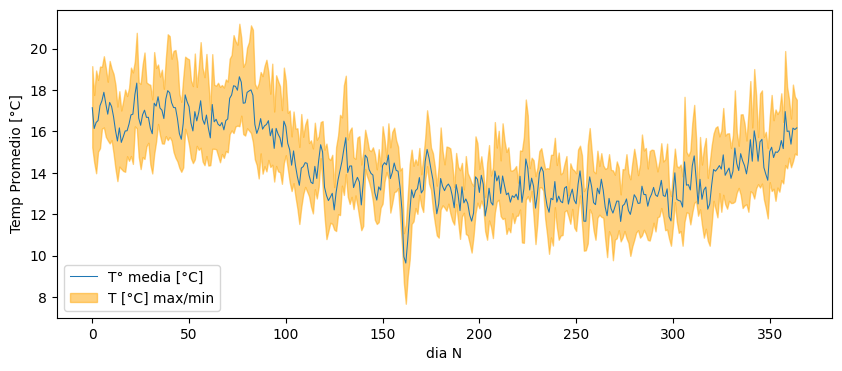

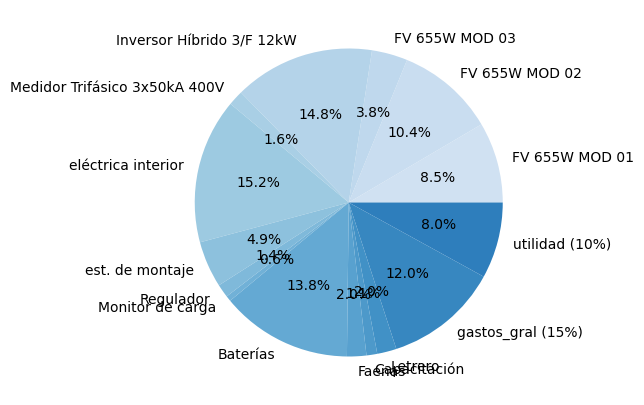

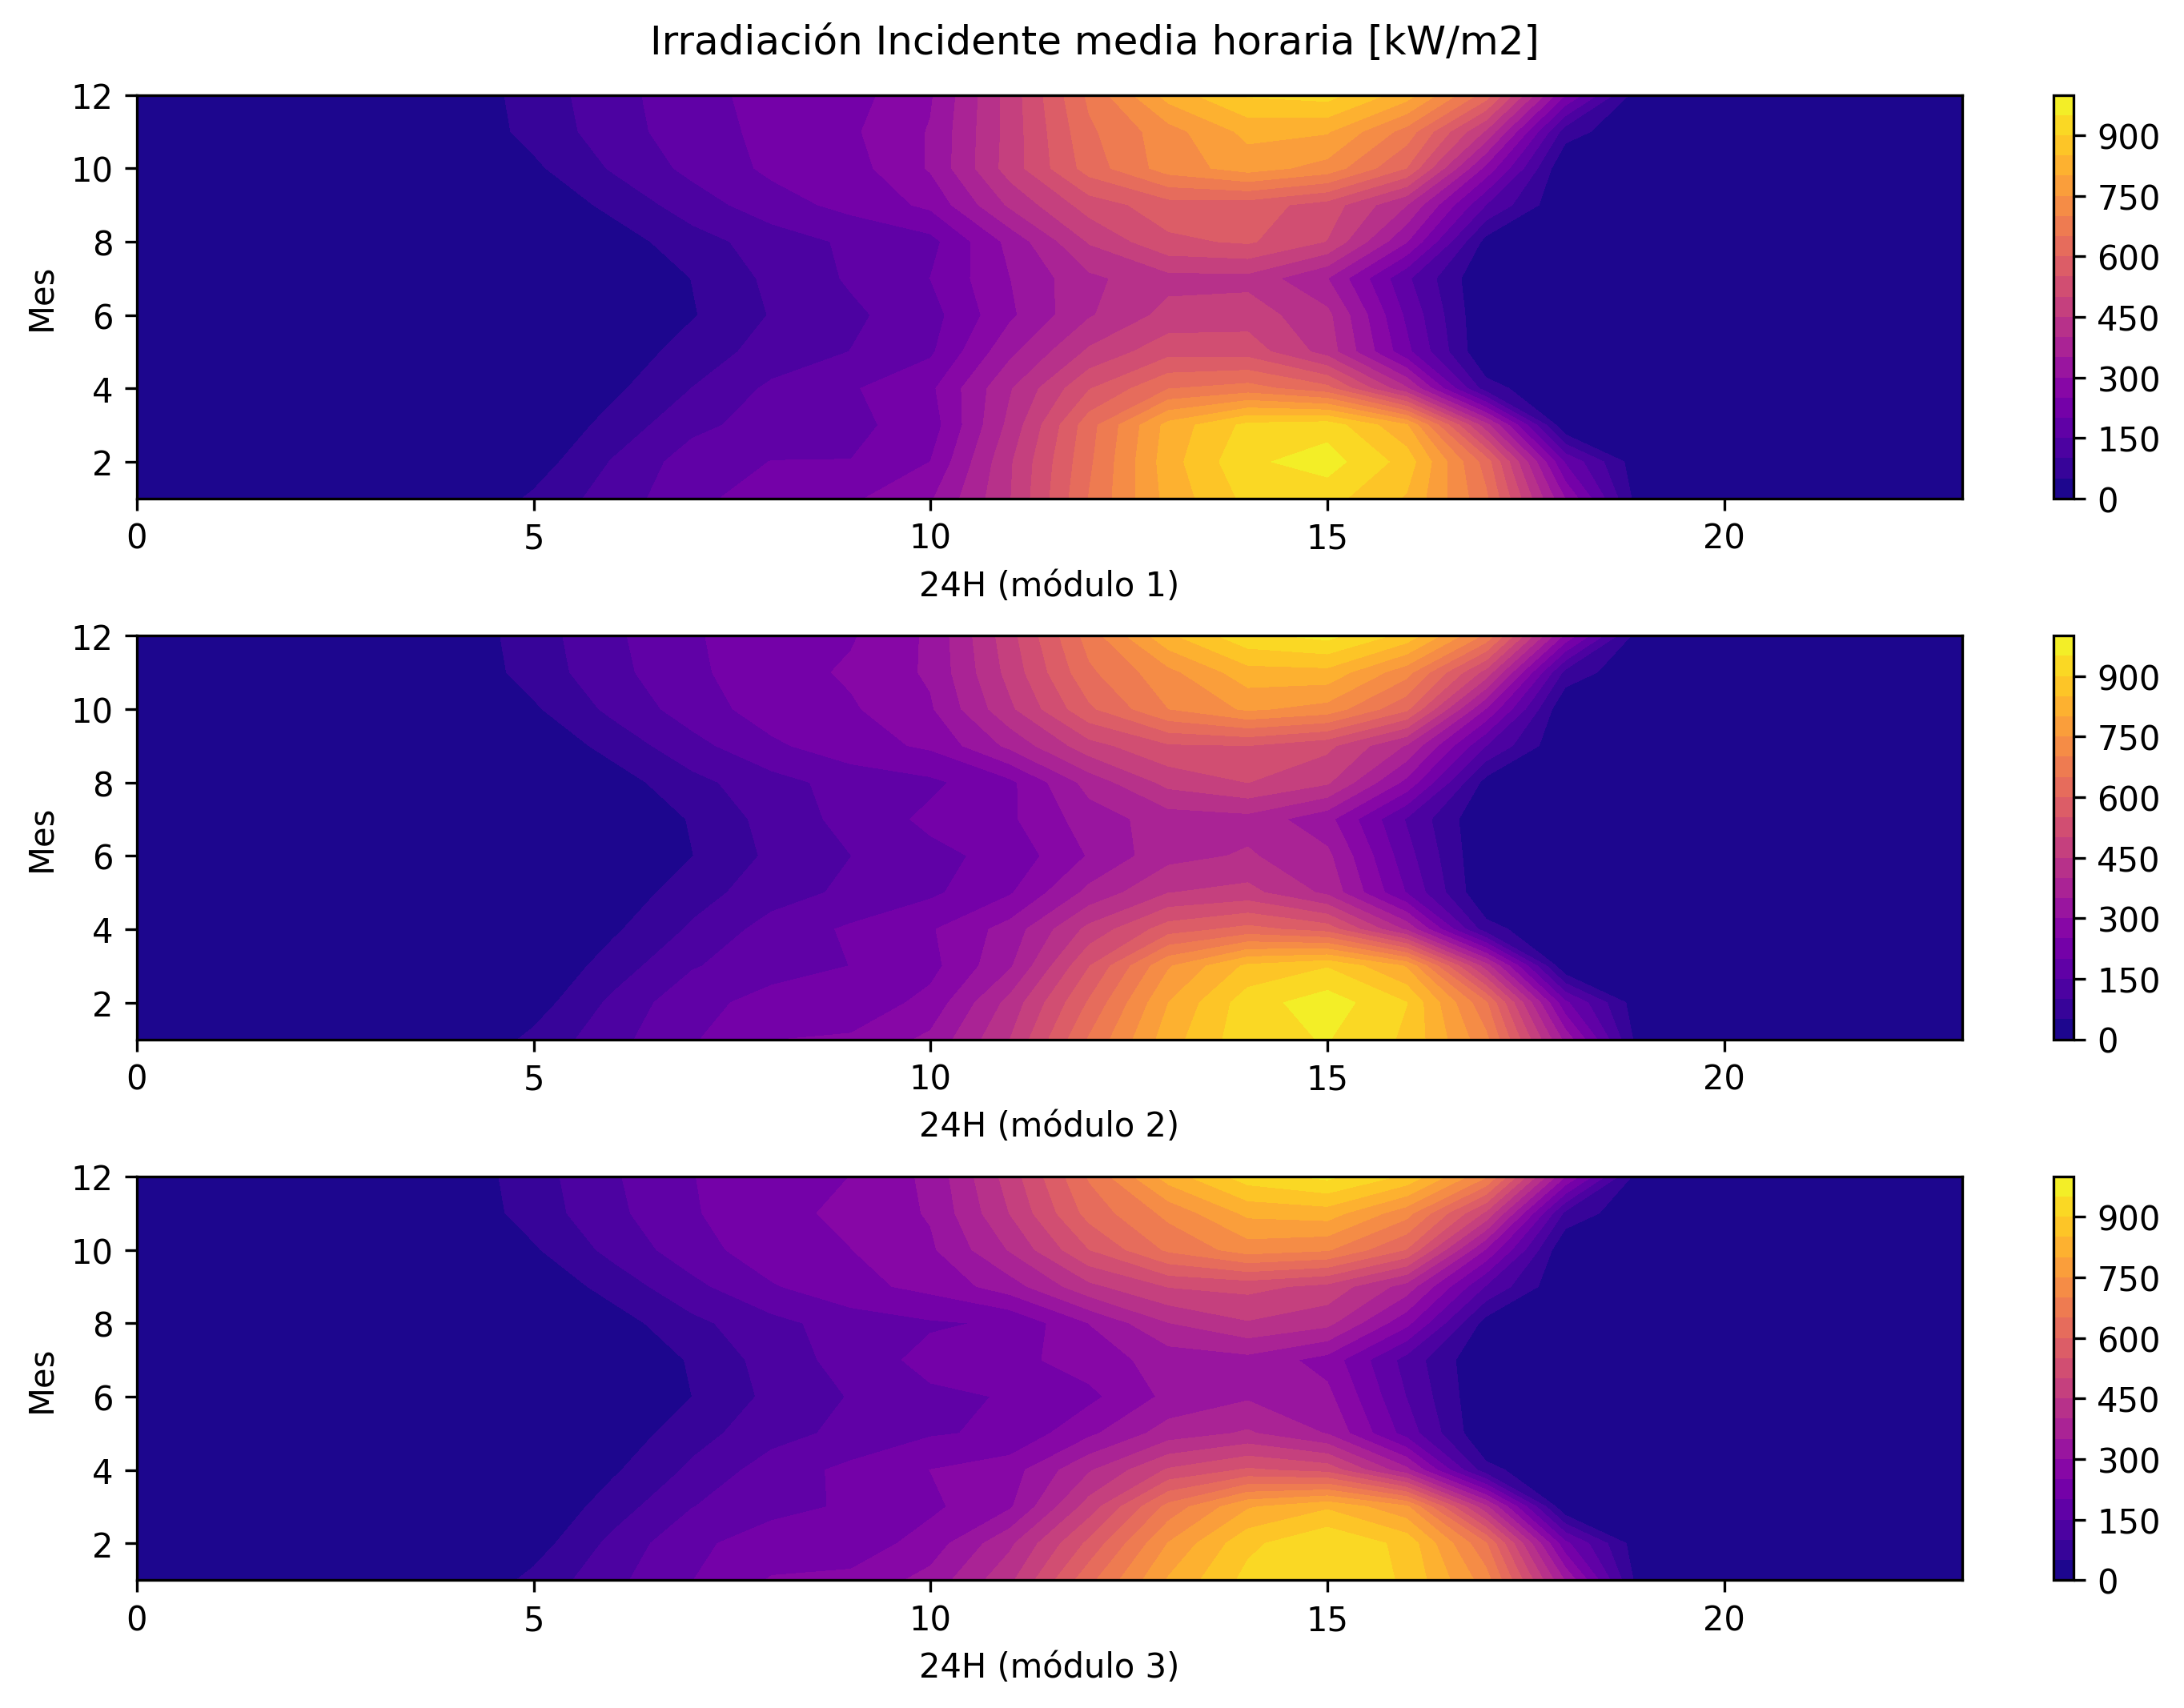

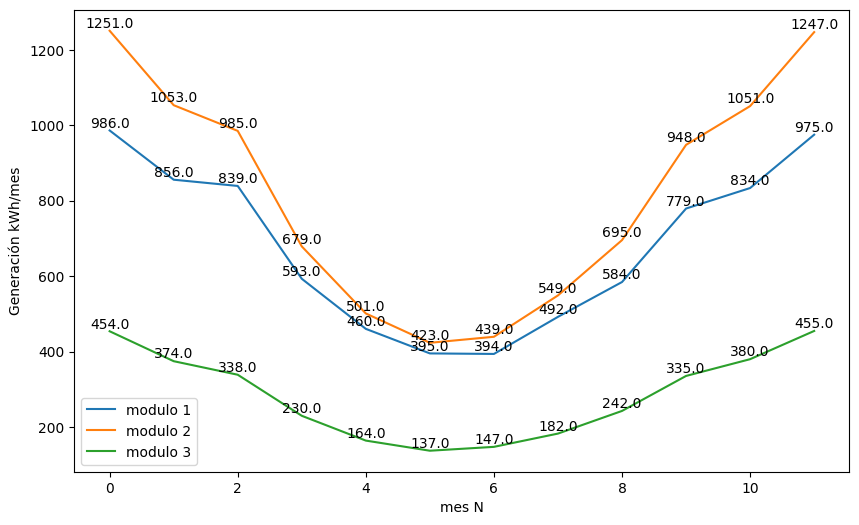

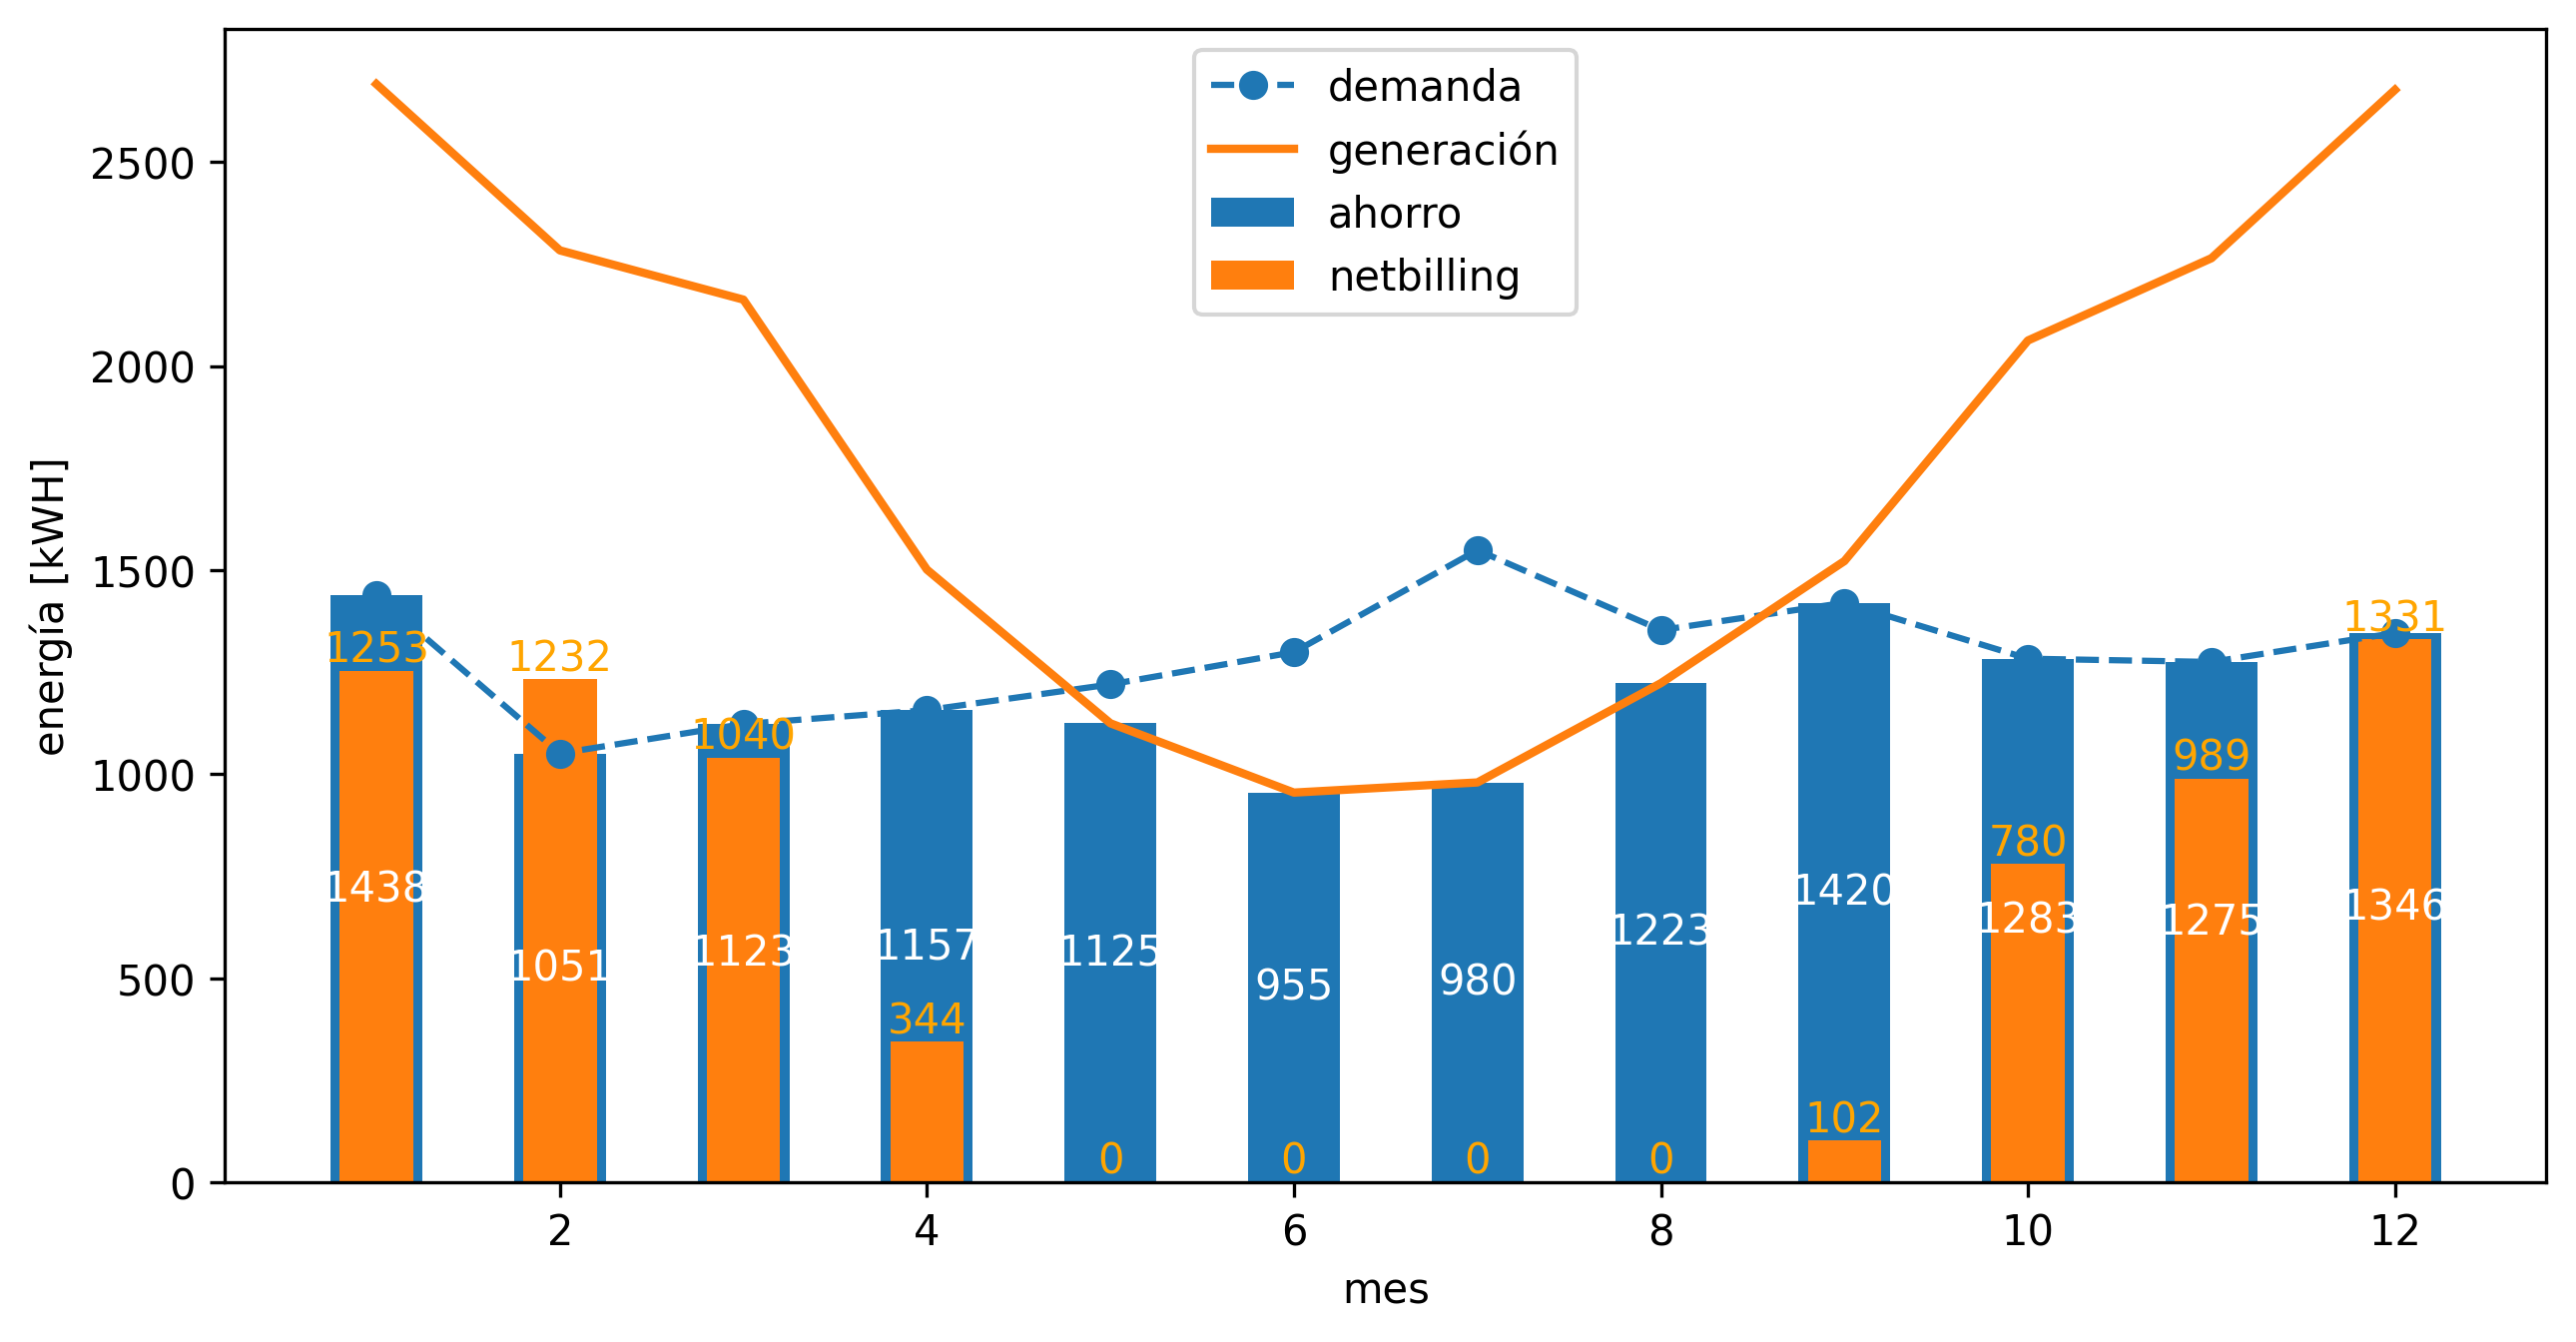

<Figure size 1920x1440 with 0 Axes>

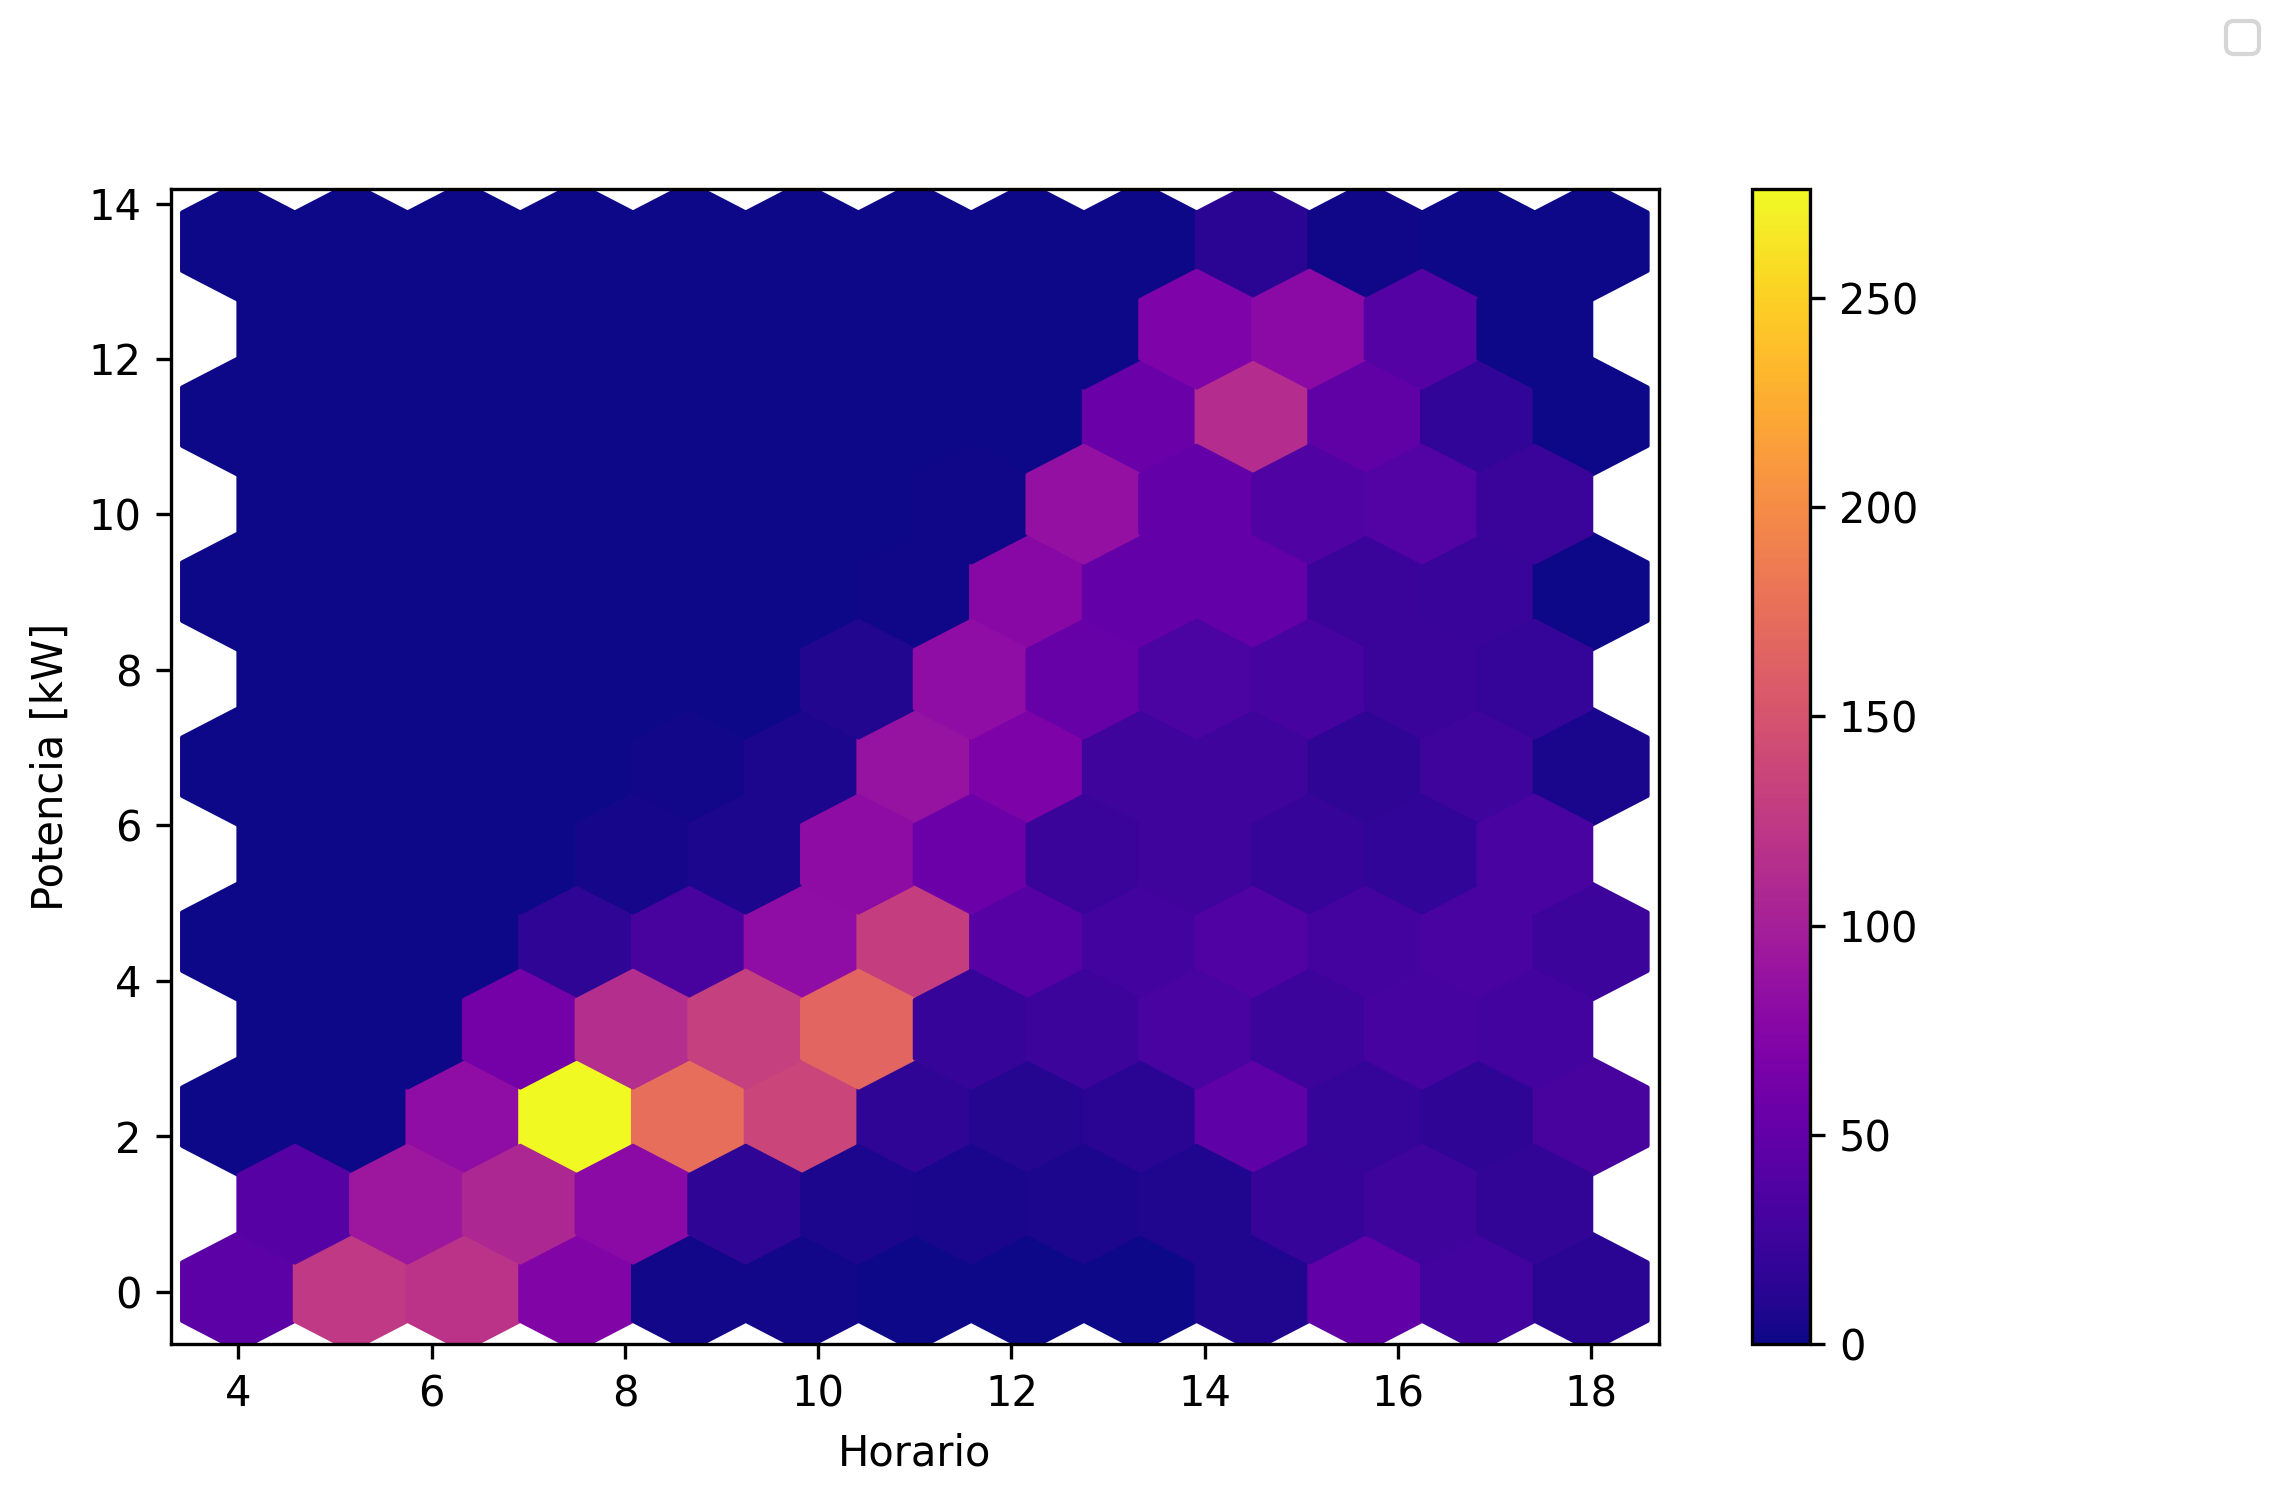

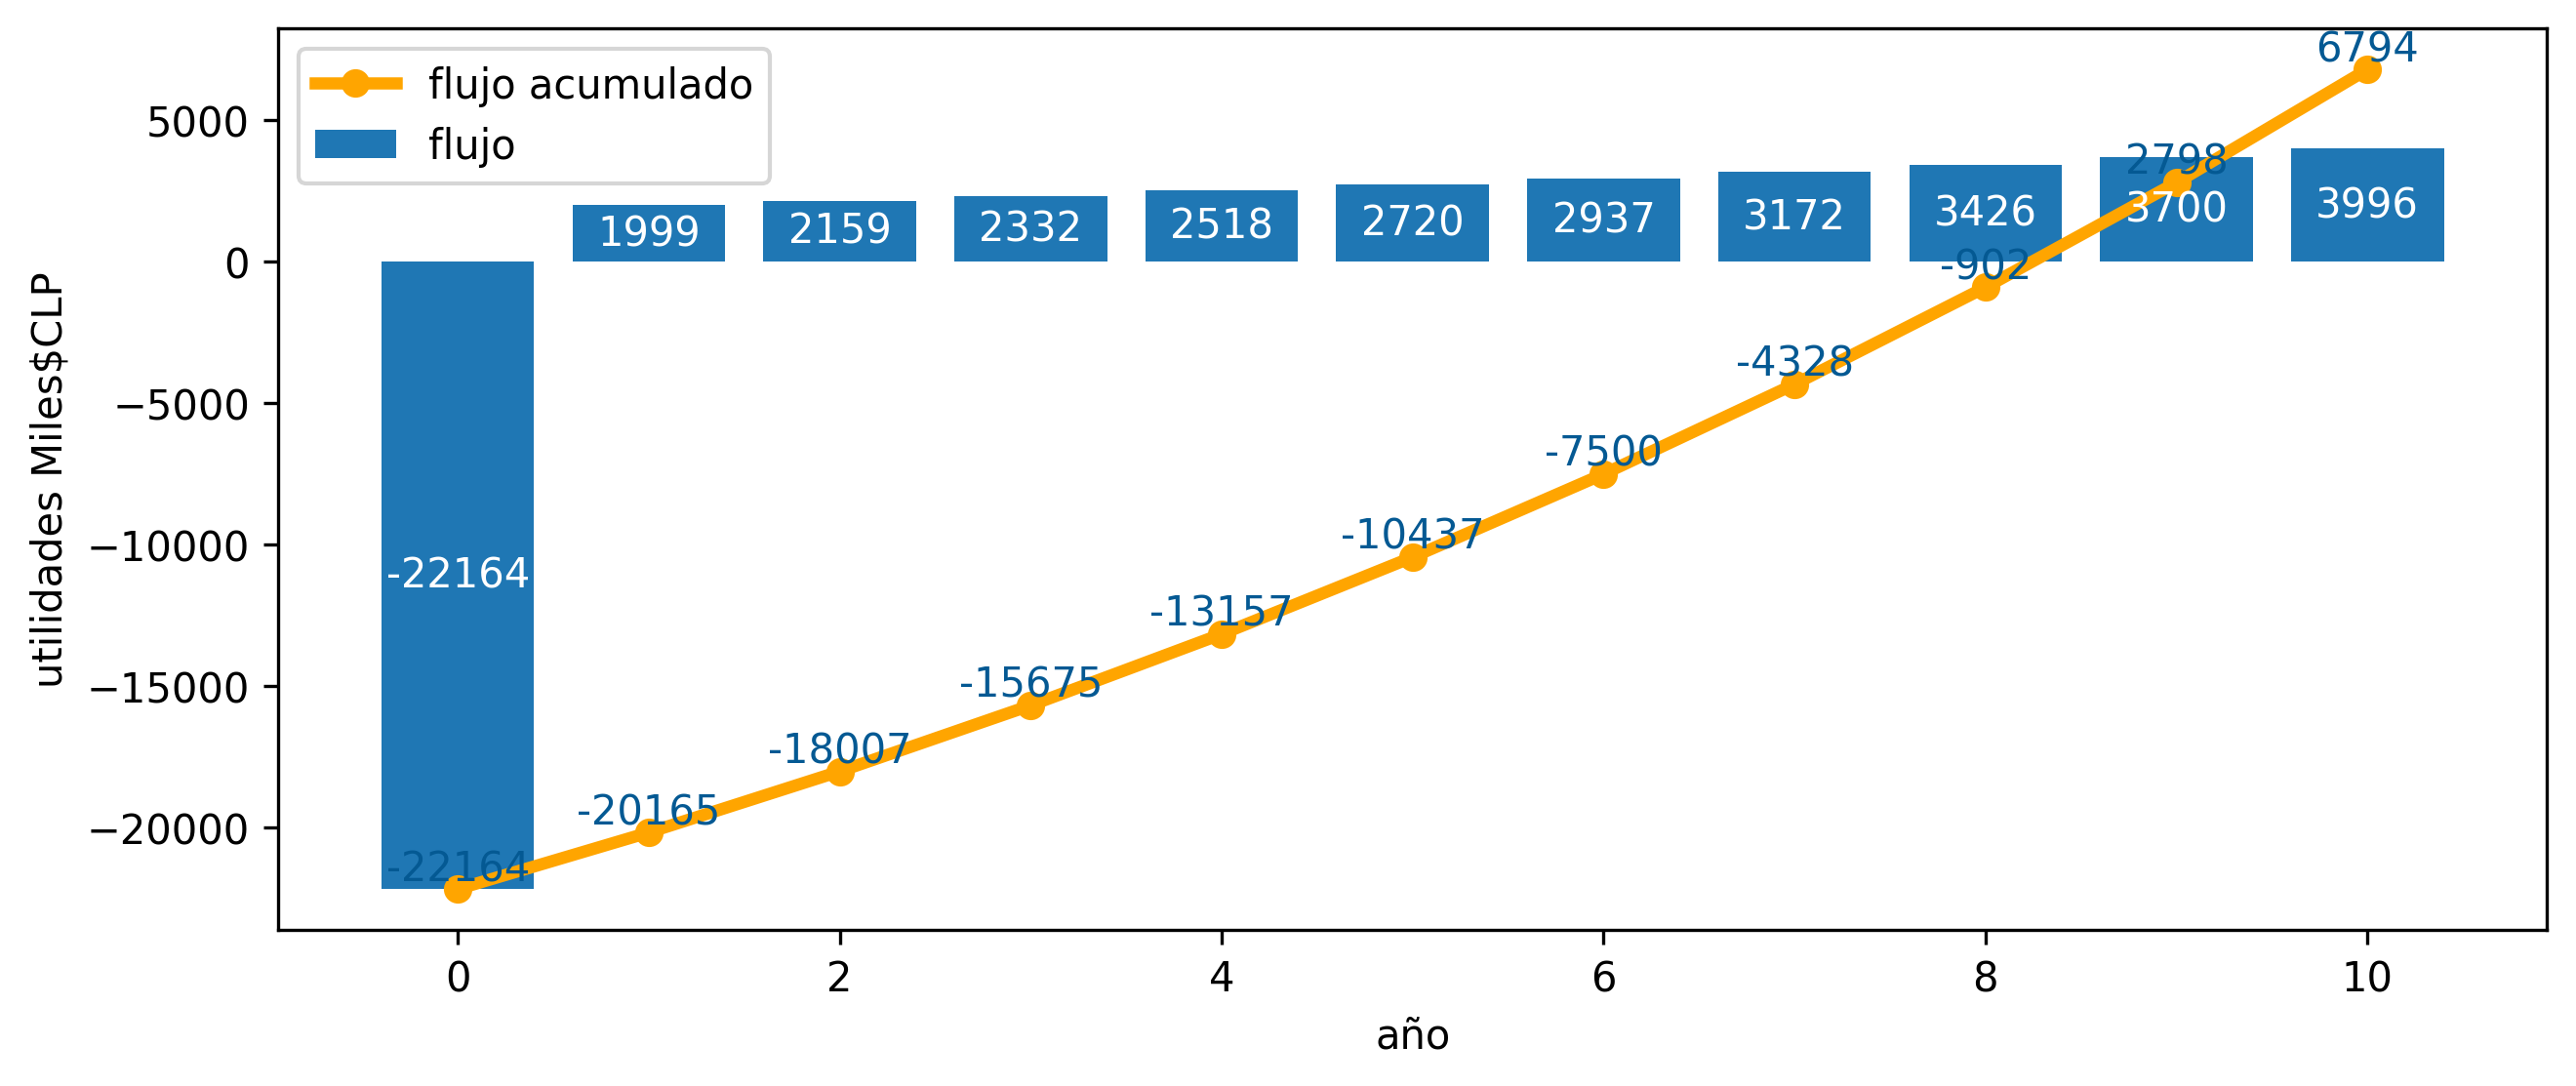

In [11]:
#dep
from models.plotter import plotter
plotter(project,PATH)

In [12]:
#set into doc
plot_list = [
    'plot_consumption_forecast',
    'plot_irradiance',
    'plot_temperature',
    'plot_components',
    'plot_components_irr',
    'plot_components_production',
    'plot_production_performance',
    'plot_performance_frequency',
    'plot_flux',
    'map_location'
]

for plot in plot_list:
    memory_report.replace_pic(plot,PATH+f'{plot}.png')
    print('replaced plot:',plot)

replaced plot: plot_consumption_forecast
replaced plot: plot_irradiance
replaced plot: plot_temperature
replaced plot: plot_components
replaced plot: plot_components_irr
replaced plot: plot_components_production
replaced plot: plot_production_performance
replaced plot: plot_performance_frequency
replaced plot: plot_flux
replaced plot: map_location


In [13]:
from datetime import datetime
memory_report.save(PATH+f"reporte_memoria_calculo.docx")
bidding_report.save(PATH+f"reporte_pliegos_técnicos.docx")
print('work',project,'finish at: ',datetime.now())

work <models.inventory.Project object at 0x0000017C67E7E3C0> finish at:  2024-12-12 16:50:10.531066
